# Cluster Tumor Supressors and Oncogenes

In [432]:
import pandas as pd
import os, sys, pickle
import gcnIO
import interpretation_avg
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
%matplotlib inline

In [308]:
# parameters
clean = False

In [5]:
model_dir = '../data/GCN/training/2018_08_16_17_46_11/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID', inplace=True)

Hyper-Parameters read from ../data/GCN/training/2018_08_16_17_46_11/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_qnorm_methpromonly1000bp_ncglabels.h5
{'lr': 0.001, 'support': 2, 'loss_mul': 30.0, 'decay': 0.0005, 'data': '../data/pancancer/iref_multiomics_qnorm_methpromonly1000bp_ncglabels.h5', 'hidden_dims': [50, 40, 30, 20, 10], 'dropout': 0.4, 'cv_runs': 10, 'epochs': 7000}


In [6]:
cancer_gene_list = pd.read_csv('../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
print ("Got {} cancer genes".format(cancer_gene_list.shape[0]))
cancer_gene_list.columns = [i.strip('*') for i in cancer_gene_list.columns]
cancer_genes = cancer_gene_list[cancer_gene_list['Gene Symbol'].isin(nodes.Name)]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} oncogenes and {} tumour suppressors".format(oncogenes.shape[0], suppressors.shape[0]))

Got 125 cancer genes
Got 52 oncogenes and 71 tumour suppressors


## Compute LRP for genes of interest

In [7]:
pkl_save_path = os.path.join(model_dir, 'onco_sup_lrp.pkl')
if not clean or not os.path.exists(pkl_save_path):
    lrp_supressors = interpretation_avg.interpretation_avg(model_dir=model_dir,
                                                          genes=suppressors['Gene Symbol'],
                                                          out_dir=None)
    lrp_oncogenes = interpretation_avg.interpretation_avg(model_dir=model_dir,
                                                          genes=oncogenes['Gene Symbol'],
                                                          out_dir=None)
    with open(pkl_save_path, 'wb') as f:
        pickle.dump(((suppressors['Gene Symbol'], lrp_supressors), (oncogenes['Gene Symbol'], lrp_oncogenes)), f)
else:
    sup, onc = pickle.load(pkl_save_path)
    sup_names, lrp_supressors = sup
    onc_names, lrp_oncogenes = onc

Load: ../data/pancancer/iref_multiomics_qnorm_methpromonly1000bp_ncglabels.h5
Calculating Chebyshev polynomials up to order 2...
Now: ACVR1B
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_08_16_17_46_11/cv_0/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_08_16_17_46_11/cv_1/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_08_16_17_46_11/cv_2/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_08_16_17_46_11/cv_3/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_08_16_17_46_11/cv_4/model.ckpt
DeepExplain: running "el

## Get the LRP features to DF

In [406]:
def get_lrp_feature_col(node_names, lrp_list, gene_name):
    idx = np.where(node_names[:, 1] == gene_name)[0]
    return lrp_list.mean(axis=0)[idx].reshape(-1)
    #return lrp_list.mean(axis=0).reshape(-1)
features_sup = []
for gene in range(suppressors.shape[0]):
    lrp_i = get_lrp_feature_col(node_names=node_names,
                                lrp_list=lrp_supressors[gene],
                                gene_name=suppressors['Gene Symbol'].iloc[gene]
                               )
    features_sup.append(lrp_i)

features_onc = []
for gene in range(oncogenes.shape[0]):
    lrp_i = get_lrp_feature_col(node_names=node_names,
                                lrp_list=lrp_oncogenes[gene],
                                gene_name=oncogenes['Gene Symbol'].iloc[gene]
                               )
    features_onc.append(lrp_i)

In [407]:
len(features_sup), len(features_onc)
X_sup = np.array(features_sup)
X_onc = np.array(features_onc)
X = np.concatenate((X_sup, X_onc))
y = np.concatenate((np.zeros(X_sup.shape[0]), np.ones(X_onc.shape[0])))

In [408]:
X_df = pd.DataFrame(X, index=pd.concat((suppressors, oncogenes))['Gene Symbol'])
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ACVR1B,2.970268e-09,-0.005452,-0.021867,1.244471e-08,0.017596,-0.012671,1.867209e-08,0.001407,0.061502,0.076974,...,-0.079497,-0.065488,-0.074617,-0.065549,-0.013152,-0.024656,-0.077800,-0.055653,-0.083635,-0.023213
APC,4.240972e-03,0.031221,-0.002694,3.080953e-02,0.020538,0.020987,7.121424e-09,0.037022,0.028384,0.028568,...,-0.006706,-0.017153,-0.007281,-0.006272,0.016206,-0.007557,-0.005487,0.001175,-0.006296,0.001923
ARID1A,-1.380899e-04,0.002036,0.002015,5.884315e-03,0.002379,0.001466,5.585464e-03,0.001651,0.001192,0.003242,...,-0.003136,-0.003011,-0.002752,-0.001455,0.001493,-0.002561,-0.002807,-0.001114,-0.003155,-0.001078
ARID1B,-6.729375e-04,0.000943,0.003410,2.745629e-03,0.001361,-0.004216,2.677715e-09,0.002687,0.003516,0.010217,...,-0.005957,-0.008597,-0.009764,-0.004264,-0.002424,-0.005528,-0.006853,-0.005034,-0.006421,-0.004597
ARID2,4.209840e-04,-0.000673,0.004019,4.737896e-03,0.003156,-0.000660,1.129105e-02,0.003147,0.001500,0.003025,...,-0.004271,-0.003911,-0.004358,-0.002693,0.001296,-0.003426,-0.003836,-0.002623,-0.004123,-0.002436


## Compute Embeddings & Plot

In [409]:
n_comp = 3
type_of_emb = 'TSNE'

if type_of_emb is 'PCA':
    dim_red = PCA(n_components=n_comp)
else:
    dim_red = TSNE(n_components=n_comp)
cols = [col for col in X_df.columns if not type(col) is str]
embedding = dim_red.fit_transform(X_df[cols])

for i in range(n_comp):
    X_df['emb_{}'.format(i)] = embedding[:, i]
X_df['Type'] = np.concatenate((['Tumor_Suppressor']*suppressors.shape[0], ['Oncogene']*oncogenes.shape[0]))

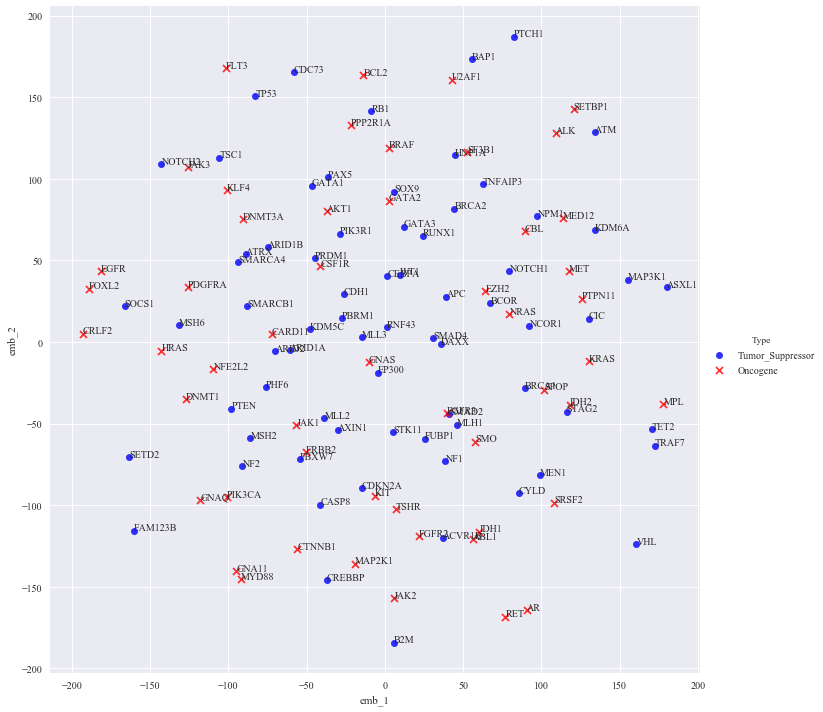

In [436]:

fig = plt.figure(figsize=(20, 10))
snsplot = sns.lmplot(data=X_df, x='emb_1', y='emb_2', hue='Type', fit_reg=False, size=10, x_jitter=0.001, y_jitter=0.001, markers=['o', 'x'],
           palette=dict(Tumor_Suppressor="b", Oncogene="r")
          )
#plt.xlim([-2, 3])
#plt.ylim([-3, 3])

for name, col in X_df.iterrows():
    plt.text(x=col.emb_1+.05, y=col.emb_2+.05, s=name)
    
snsplot.savefig(os.path.join(model_dir, 'embedding_{}.png'.format(type_of_emb)), dpi=300)

## Clustering

In [411]:
from sklearn.cluster import KMeans
cols = [col for col in X_df.columns if not type(col) is str]
pred = KMeans().fit_predict(X_df[cols], y)

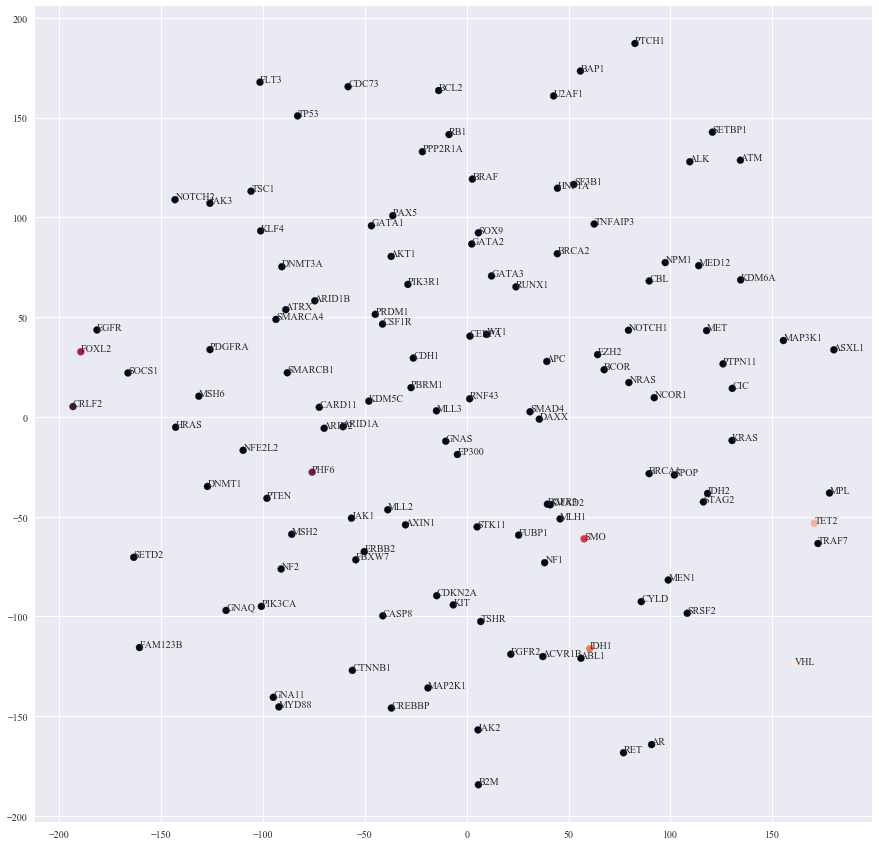

In [435]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(x=X_df.emb_1, y=X_df.emb_2, c=pred)
#plt.xlim([-2, 3])
#plt.ylim([-3, 3])

for name, col in X_df.iterrows():
    plt.text(x=col.emb_1+.05, y=col.emb_2+.05, s=name)

In [413]:
X_df[pred != 0]

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,emb_0,emb_1,emb_2,Type
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
PHF6,-9.275001e-01,-3.831275e+00,7.485776e-07,-2.831604e+00,-1.360088e+00,-1.444747e+00,4.001889e+00,-2.086856e+00,-5.920082e-01,-8.265155e+00,...,-1.721283,-2.053567,-0.523838,-2.322487,-2.139486,-2.035540,-203.025070,-75.786163,-27.696089,Tumor_Suppressor
TET2,-6.804367e-01,8.138619e-02,2.210312e-07,-8.652083e-01,-2.042510e-01,-5.364535e-01,1.814370e+00,-7.580638e-02,-5.186981e-01,-2.311723e-07,...,-0.427333,-0.508711,-0.191707,-0.492537,-0.361409,-0.462747,60.847279,170.472092,-53.276379,Tumor_Suppressor
VHL,2.158387e-07,1.836184e-07,5.764786e-08,1.102440e-07,7.086292e-08,7.865146e-01,1.360924e-07,2.651473e-07,1.416840e+00,2.683262e-07,...,0.072131,0.032113,0.085919,-0.410880,-0.195867,-0.107562,-27.563522,160.777466,-123.990456,Tumor_Suppressor
CRLF2,2.036560e-07,1.852460e-07,1.209138e-06,-1.204817e-07,-2.654003e-07,3.696239e-07,1.049319e-06,3.064516e-07,2.912855e-07,-1.344913e-06,...,-1.739870,-0.581779,0.682347,-0.701080,-0.248890,-0.117705,-36.205807,-193.114746,5.178675,Oncogene
FOXL2,1.332780e-07,-5.774094e-08,1.299366e-06,-9.084754e-08,-6.150285e-07,1.961148e-07,1.008152e-06,2.083688e-07,4.614569e-08,-1.771517e-06,...,-0.594572,-1.043863,0.387919,-4.043250,-0.722671,-2.604725,-62.814877,-189.287552,32.656521,Oncogene
IDH1,2.317182e-01,1.708727e+00,1.727236e-07,1.095135e+00,9.244526e-01,5.648005e-01,2.436830e+00,-5.183398e-01,6.544294e-01,1.326216e-07,...,-0.540866,-1.210701,-1.024550,-0.332657,-1.553579,-0.739177,-135.408859,60.448177,-116.158951,Oncogene
SMO,1.800723e-01,-1.203945e+00,2.974766e-07,1.377531e+00,6.820115e-01,3.863652e-01,5.077781e-07,-8.552990e-01,1.049845e+00,2.164957e-07,...,-0.287154,-1.018012,-1.179951,-1.549323,-1.238081,-1.273520,-147.948074,57.626884,-61.102291,Oncogene


In [433]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = linkage(X_df[cols], 'ward')
c, coph_dists = cophenet(Z, pdist(X_df[cols]))
c

0.9744418297506797

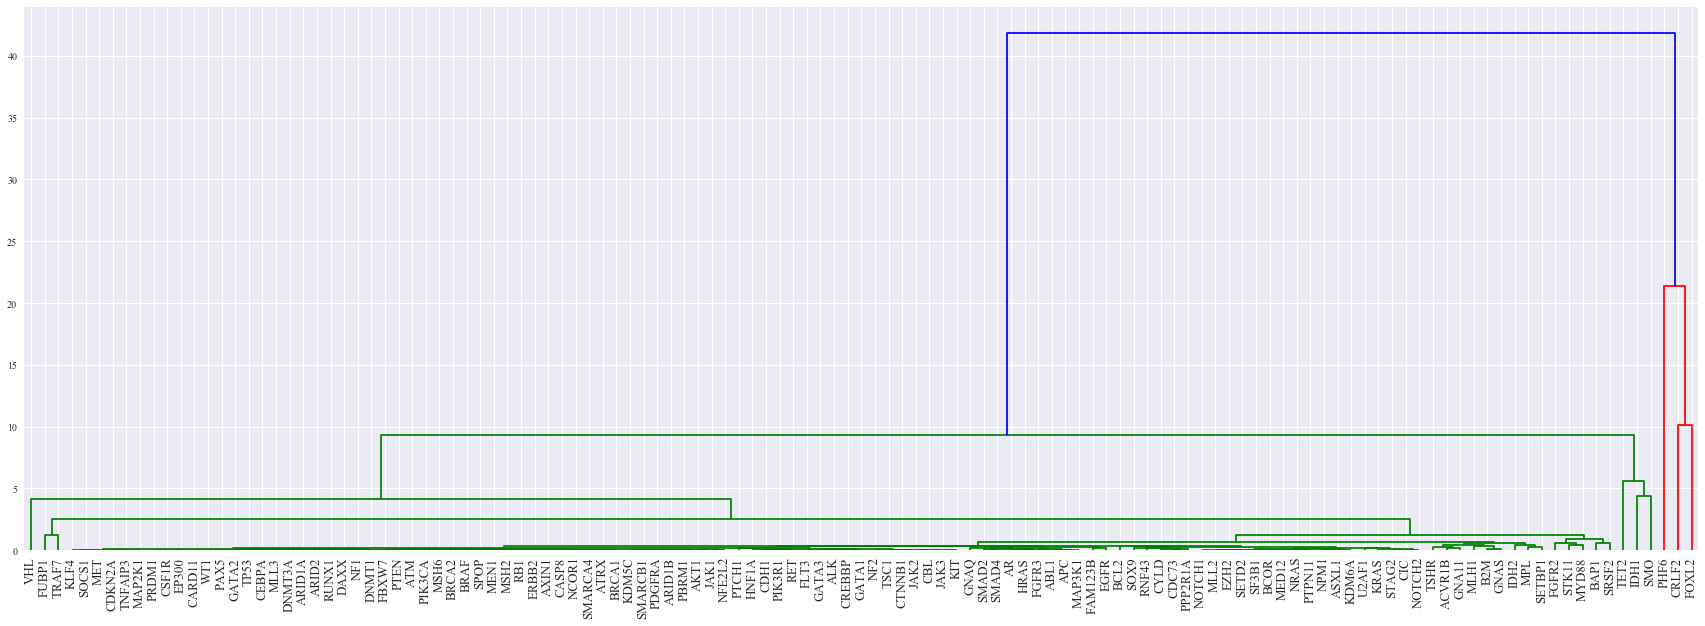

In [434]:
fig = plt.figure(figsize=(30, 10))
_ = dendrogram(Z, leaf_rotation=90, labels=X_df.index, leaf_font_size=13)
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes.svg'))
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes.png'), dpi=300)


In [443]:
cancers[cancers['Gene Symbol'] == 'PHF6']

,Gene Symbol,Gene Name,# Mutated Tumor Samples,Ocogene score*,Tumor Suppressor Gene score*,Classification,Core pathway,Process
90,PHF6,PHD finger protein 6,57,18%,61%,TSG,Transcriptional Regulation,Cell Fate
